In [1]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime
from sklearn.decomposition import PCA, KernelPCA
from numpy import linalg as LA

In [2]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
K, N, T = X.shape
print(X.shape)

(108, 218, 61)


In [3]:
def soft_normalize(X):
    X_norm_const = jnp.maximum(jnp.max(X, axis=(0,2),  keepdims=True ), 0.1)
    X_normalized = X / X_norm_const
    mean_across_conditions = jnp.mean(X_normalized, axis=0, keepdims=True) 
    X_normalized = X_normalized - mean_across_conditions
    return X_normalized

def normalize(X):
    mean_across_conditions = jnp.mean(X, axis=0, keepdims=True) 
    X_normalized = X - mean_across_conditions
    return X_normalized


In [6]:
def single_pair_loss(U_tilde, X, id_1, id_2):                           #U (N,d); X(K,N,T)

    Y = jnp.einsum('ji,jk->ik', U_tilde, X[id_1, :, :])                 #(d,T)
    Y_prime = jnp.einsum('ji,jk->ik', U_tilde, X[id_2, :, :])           #(d,T)

    YY = jnp.einsum('ij,kj->ik', Y, Y_prime)                            #(d,d)
    YY_product = jnp.einsum('ij,lm->im', YY, YY)                        #(d,d)

    S_pair = jnp.trace(YY)**2 - jnp.trace(YY_product)
    return S_pair

def loss(params, X, key, s_learn):  
    K, N, T = X.shape
    if s_learn:
        U = params['U_dict']
        s = params['s_dict'] 

        s_normalized = jnp.sqrt(N) * (s**2) /  jnp.linalg.norm(s)
        X_scaled = s_normalized[None, :, None] * X
    else:
        U = params
        X_scaled = X
    
    U_tilde, _ = jnp.linalg.qr(U)

    num_pairs = 100  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(U_tilde, X_scaled, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    S = (2 / (num_pairs**2) ) * jnp.sum(batched_loss)
    return -S

def update_U(params, X, optimizer, opt_state, key, s_learn):
    dL_dU = grad(loss)(params,X,key, s_learn)
  
    updates, opt_state_updated = optimizer.update(dL_dU, opt_state, params)
    params_updated = optax.apply_updates(params, updates)
    return params_updated, opt_state_updated

def optimize_U(X, s_learn=False, iterations=10000, learning_rate=0.001, d=4, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    
    U = random.normal(key, (N, d))
    s = random.normal(key, (N,)) 

    if s_learn:
        params = {
            'U_dict': U,
            's_dict': s
        }
    else: 
        params = U 

    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    
    ls_loss = []
    cmap = plt.get_cmap('viridis')
    for i in range(iterations):
        params, opt_state = update_U(params, X, optimizer, opt_state, keys[i], s_learn)
        
        ls_loss.append(loss(params, X, keys[i], s_learn))
        
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss(params, X, keys[i], s_learn)}")
            
        if i % 100 == 0:
            plt.figure()
            plt.plot(ls_loss)
            plt.savefig(f'outputs/linear_sca/fig_saved/loss_lr_{learning_rate}_iter_{iterations}_d_{d}.png' )
        #     plt.plot(params['s_dict'], color=cmap(i / (iterations - 1)))
    
    
    return params, ls_loss

s_learn = True
iterations=10000
learning_rate=0.001
d = 4
optimized_params, ls_loss = optimize_U(soft_normalize(X), s_learn, iterations, learning_rate, d)                     #optimized_U (N,d)

now = datetime.datetime.now()
date_time_str = now.strftime('%d%m%Y_%H%M%S')

#save_path_U = 'outputs/linear_sca/optimized_U_linear_SCA/optimized_U_' + date_time_str

save_path_U = f'outputs/linear_sca/optimized_U_linear_SCA/optimized_U_lr_{learning_rate}_iter_{iterations}_d_{d}' 

if s_learn:
    optimized_U = optimized_params['U_dict']
    
    optimized_s = optimized_params['s_dict']
    #save_path_s = 'outputs/linear_sca/optimized_U_linear_SCA/optimized_s_' + date_time_str
    save_path_s = f'outputs/linear_sca/optimized_U_linear_SCA/optimized_U_lr_{learning_rate}_iter_{iterations}_d_{d}' 
    np.save(save_path_s, optimized_s)
else:
    optimized_U = optimized_params

np.save(save_path_U, optimized_U)

Iteration 0, S: 0.366415798664093
Iteration 10, S: 0.4400627911090851
Iteration 20, S: 0.7253897786140442
Iteration 30, S: 0.836901843547821
Iteration 40, S: 1.0857163667678833
Iteration 50, S: 1.4419444799423218
Iteration 60, S: 1.6336660385131836
Iteration 70, S: 2.255557060241699
Iteration 80, S: 3.374124050140381
Iteration 90, S: 3.4571733474731445
Iteration 100, S: 4.327630519866943
Iteration 110, S: 7.025057792663574
Iteration 120, S: 10.0211763381958
Iteration 130, S: 13.953879356384277
Iteration 140, S: 16.609214782714844
Iteration 150, S: 27.40218734741211
Iteration 160, S: 48.05386734008789
Iteration 170, S: 51.103694915771484
Iteration 180, S: 73.54887390136719
Iteration 190, S: 81.34085083007812
Iteration 200, S: 102.1630630493164
Iteration 210, S: 156.1810760498047
Iteration 220, S: 201.67665100097656
Iteration 230, S: 272.10546875
Iteration 240, S: 364.9404602050781
Iteration 250, S: 519.4624633789062
Iteration 260, S: 569.3930053710938
Iteration 270, S: 726.9849243164062

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_96894/4132310088.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Iteration 2010, S: 6407934.5
Iteration 2020, S: 6792215.0
Iteration 2030, S: 7218688.5
Iteration 2040, S: 5302184.0
Iteration 2050, S: 7458729.0
Iteration 2060, S: 5659946.0
Iteration 2070, S: 5421709.0
Iteration 2080, S: 6016351.5
Iteration 2090, S: 5231420.0
Iteration 2100, S: 5576259.0
Iteration 2110, S: 6414850.5
Iteration 2120, S: 7981733.5
Iteration 2130, S: 7534922.0
Iteration 2140, S: 6100671.5
Iteration 2150, S: 8226545.5
Iteration 2160, S: 7637466.0
Iteration 2170, S: 7716985.0
Iteration 2180, S: 7635370.0
Iteration 2190, S: 8036111.0
Iteration 2200, S: 6991263.0
Iteration 2210, S: 7374893.5
Iteration 2220, S: 7892690.5
Iteration 2230, S: 7267100.0
Iteration 2240, S: 9422912.0
Iteration 2250, S: 9018206.0
Iteration 2260, S: 8087440.5
Iteration 2270, S: 9393014.0
Iteration 2280, S: 9326312.0
Iteration 2290, S: 8837778.0
Iteration 2300, S: 7633536.5
Iteration 2310, S: 11146554.0
Iteration 2320, S: 12349695.0
Iteration 2330, S: 10049646.0
Iteration 2340, S: 10868042.0
Iteration 

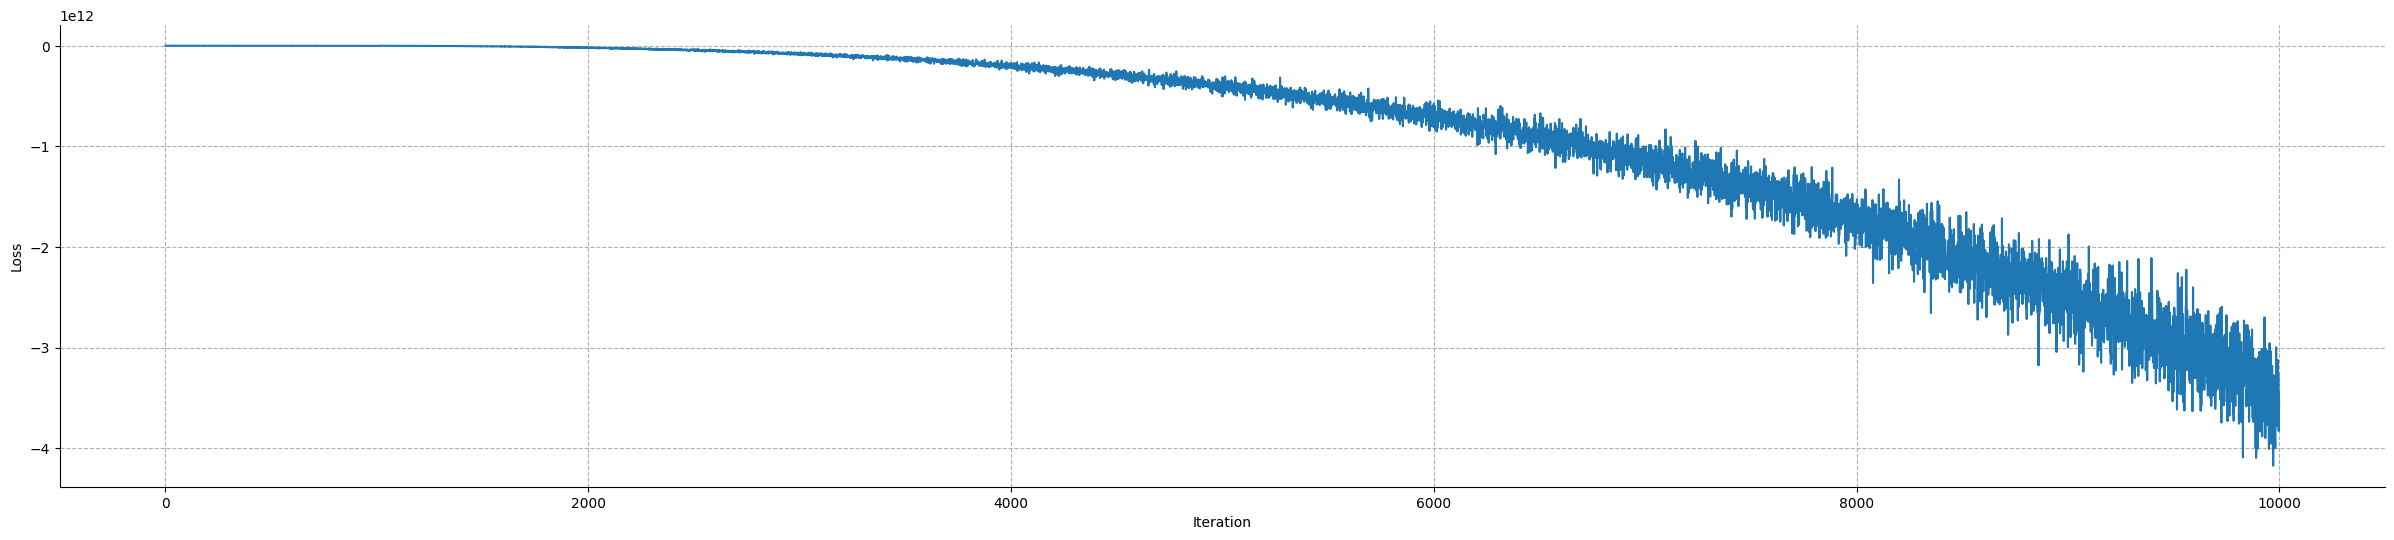

In [5]:
plt.figure(figsize=(30, 6))
plt.plot(ls_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--") 
plt.gca().spines[['right', 'top']].set_visible(False)


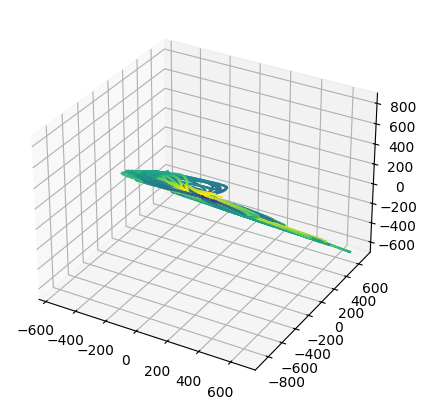

In [6]:
# threshold = 0.025
# mask = jnp.abs(optimized_s) > threshold
# indices = jnp.where(mask)[0]
# print(indices)

s_normalized = jnp.sqrt(N) * (optimized_s ** 2) / jnp.linalg.norm(optimized_s)
X_scaled = s_normalized[None, :, None] * soft_normalize(X[:,:,:])

optimized_U_tilde, _ = jnp.linalg.qr(optimized_U)        
Y = jnp.einsum('ji,kjl->kil', optimized_U_tilde[:,:], X_scaled)         #(K,d,T) 

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig) 
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],1)

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  

    
    for t in range(num_time_points - 1):
        #ax.scatter(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1))) 
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))


In [7]:
def make_frame(angle):
    ax.view_init(30, angle)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0, 180, 2) 
frames = [make_frame(angle) for angle in angles]

gif_path = date_time_str + "_trajectories_rotation_test_2.gif"
imageio.mimsave(gif_path, frames, fps=20)

gif_path

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_96677/3152943548.py:4: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


'22052024_113002_trajectories_rotation_test_2.gif'

ENDS HERE 

In [ ]:
# mean_X = jnp.mean(soft_normalize(X), axis=0)
# print(mean_X.shape)

# plt.figure(figsize=(10,3))
# idx_plot = [33, 43, 163, 193, 195]
# n_plots = len(idx_plot)
# for i, id in enumerate(idx_plot):
#     plt.subplot(n_plots,1,i+1)
#     #plt.plot(mean_X[id])
#     plt.plot(soft_normalize(X)[10,id,:])
#     plt.gca().spines['top'].set_visible(False) 
#     plt.gca().spines['right'].set_visible(False) 
# plt.subplots_adjust(hspace=0.8)

# print(jnp.mean(abs(mean_X[idx_plot,:])))
# print(jnp.mean(abs(mean_X[:,:])))

plt.figure()
for k in range(K):
    plt.plot(soft_normalize(X)[k,42,:])

In [50]:
#PCA 
D = 3
X_reshaped = X.reshape(K * T, -1)  

pca = PCA(n_components=D)
kernel_pca = KernelPCA(
    n_components=D, kernel="rbf", gamma=10, fit_inverse_transform=True, alpha=0.1
)

pca.fit(X_reshaped)
PCs = pca.components_           #(D, N)


Y_kernel = kernel_pca.fit(X_reshaped).transform(X_reshaped)


Y = jnp.einsum('ij,kjl->kil', PCs,X)                      #(K,D,T) 
Y_kernel = Y_kernel.reshape(K, T, D).swapaxes(1,2)


In [34]:
#PCA (by hand)
X_reshaped = normalize(X).reshape(K, -1)  
cov = np.cov(X_reshaped)
eigenvalues, eigenvectors = LA.eig(cov)

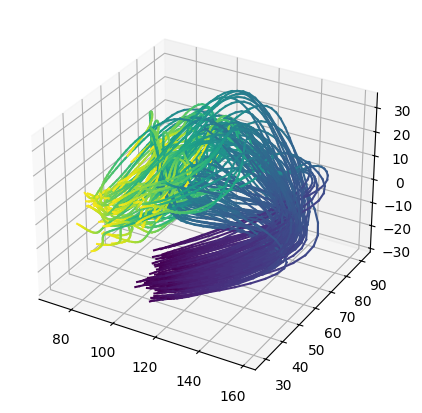

In [51]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')


num_time_points = Y.shape[-1]                   #(K, d, t)
indices_to_plot = np.arange(0,Y.shape[0],1)

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))